# Table of Contents
* [Uncertainty quantification in sunspot counts](#Uncertainty-quantification-in-sunspot-counts)
	* [Rescaled observations](#Rescaled-observations)
	* [Proxy for the solar signal: s(t)](#Proxy-for-the-solar-signal:-s%28t%29)
	* [Error at minima](#Error-at-minima)
	* [Error at short-term](#Error-at-short-term)
	* [Error at long-term](#Error-at-long-term)
* [Other products](#Other-products)
	* [Variability / sigma](#Variability-/-sigma)
	* [Measure of stability (at short-term and long-term)](#Measure-of-stability-%28at-short-term-and-long-term%29)
	* [Individual errors (error bars)](#Individual-errors-%28error-bars%29)


# Uncertainty quantification in sunspot counts

In <a id="ref-1" href="#cite-Mathieu2019">(Mathieu 2019)</a>, we develop a general uncertainty model valid for:

- the number of spots: $Ns$
- the number of groups: $Ng$ 
- the Wolf number, a composite defined as $N_c =N_s + 10 N_g$ <br>

Let the index i, $1 \leq i \leq N$ denote the observatory, also called station, and $t$, $1 \leq t \leq T$ represent the time. <br>
The raw observations/counts (representing Ns, Ng or Nc), generically denoted by $Yi(t)$, may be decomposed into a common solar signal, $s(t)$, corrupted by three types of station-dependent errors  : <br>

$$ Yi(t) = (\epsilon_1(i,t) + \epsilon_2(i,t)) s(t) + \epsilon_3(i,t) $$ 
where : <br>
- $\epsilon_1$ denotes the short-term error (i.e. error inferior to 27 days) representing counting errors and variable seeing conditions;
- $\epsilon_2$ is a long-term error (superior or equal to 27 days) accounting for systematic bias in the counting; 
- $\epsilon_3$, which is occurring only at solar minima (when $s(t)$ is equal to zero); it captures effects like short-duration sunspots and the non-simultaneity of the observations across the network of stations. <br>


In the following, the different terms of the model are estimated, for Nc, Ns and Ng. 

In [1]:
#load packages
import pickle
import numpy as np 
import pkg_resources as pkg
from scipy.stats import iqr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
import warnings
warnings.filterwarnings("ignore")

### load data (loaded automatically with package)
data_path = pkg.resource_filename(pkg.Requirement.parse("uncertainty"), 'data')

# load data (subset of 21 stations to reproduce the results of Mathieu, 2019)
with open(data_path + '\data_21_1947', 'rb') as file:
#with open('../data/data_21_1947', 'rb') as file: #local
    my_depickler = pickle.Unpickler(file)
    Ns = my_depickler.load() #number of spots
    Ng = my_depickler.load() #number of sunspot groups
    Nc = my_depickler.load() #Ns+10Ng
    station_names = my_depickler.load() #index of the stations
    time = my_depickler.load() #time (fraction of years)

## Rescaled observations 

Due to the different characteristics of the observing means (telescope aperture, location, personal experience etc.),
each station has its own scaling. These differences mainly impact the count of small spots, which cannot be observed
with low-resolution telescopes, and the splitting of complex groups, where the personal experience of the observer
matters. A rescaling is thus needed to readjust all stations to the same level when comparing stations on the
short-term and at solar minima. <br>
First, the "time-scale", that is, the duration of the period where the scaling-factors are assumed to be
constant, should be selected.  A statistical-driven study based on the Kruskal-Wallis
test <a id="ref-2" href="#cite-Kruskal_Wallis">(Kruskal & Wallis 1952)</a> shows that the smallest time-scales are <a id="ref-3" href="#cite-Mathieu2019"> (Mathieu 2019, section 4)</a>:
- 8 months for Ns
- 14 months for Ng 
- 10 months for Nc <br>

Second, having determined the minimal time-scale, the scaling-factors, $\kappa_i(t)$, are calculated using the ordinary least-squares regression (OLS) of the observations on the median of the network. <br>
The rescaled data, denoted $Zi$, are defined as 

$$ Z_i(t) = \frac{Y_i(t)}{\kappa_i(t)} $$

In [2]:
def rescaling(data, period_rescaling):
    """
    Rescales the data wrt the median of the panel.
    
    This function rescales the observations on the median of the panel using 
    piece-wise constant scaling-factors. These factors are computed using a 
    simple linear regression of the observations on the median without 
    intercept.
    
    Parameters
    ----------
    data : 2D-array 
        A matrix of observations to be rescaled: either Ns, Ng or Nc
        (rows: time, columns: stations).
    period_rescaling : float>0
        Length of the period where the scaling-factors are assumed to be 
        constant, expressed in months.
        Using a statistical procedure based on Kruskal-Wallis tests, 
        the minimum value for this parameter is found to be equal to 
        8 months for Ns, 14 months for Ng and 10 months for Nc.
        
    Returns: 
    -------
    obs_rescaled : 2D-array
        A matrix with the rescaled observations
        
    """
    assert np.ndim(data) == 2, "Input data must be a 2D array"
    assert period_rescaling > 0, "Period must be strictly positive"
    (n_obs, n_stations) = data.shape
    month = int(365/12)
    step = int(period_rescaling*month)
    n = int(np.ceil(n_obs/step))
    
    med = np.nanmedian(data, axis=1)#create warnings: sometimes all values are Nans

    #### linear regression
    slopeOLSY = np.ones((n, n_stations)) 
    for j in range(n_stations):
        c = 0
        for i in range(0, n):
            X = data[c:c+step,j]
            Y = med[c:c+step]
            ind = np.where(~np.isnan(X))
            Y = Y[ind].reshape(-1,1) 
            X = X[ind].reshape(-1,1)
            c += step
            if len(Y > 0) > 2 and len(X > 0) > 2:
                reg = LinearRegression(fit_intercept=False).fit(X, Y)
                slopeOLSY[i,j] = reg.coef_ #slope
        
    
    ### effective rescaling 
    obs_rescaled = np.zeros((n_obs, n_stations)) 
    for j in range(n_stations):
        c = 0
        for i in range(0, n):
            if slopeOLSY[i,j] > 0 and not np.isnan(slopeOLSY[i,j]):
                obs_rescaled[c:c+step,j] = data[c:c+step,j] * slopeOLSY[i,j]
            c += step
    
    return obs_rescaled

## Proxy for the solar signal: s(t)

Once the observations are rescaled, we may estimate $s(t)$, a latent variable representing the `true' solar signal, i.e. the actual number of spots Ns, groups Ng or composite Nc lying on the Sun. $s(t)$ cannot be directly observed as the counts of the stations are corrupted by different error sources. Our goal is here to estimate the mean of s(t), denoted by $\mu_s(t)$, which will be used as a proxy for s(t) in the following. <br>

A robust estimator for $\mu_s(t)$ may be defined as a transformed version of the median of the network:

$$ \hat \mu_s(t) = T(Mt) $$

where 

$$Mt = \underset{1 \leq i \leq N} {med} Zi(t)$$

represents the median of the network, and T denotes a transformation composed of an Anscombe transform <a id="ref-4" href="#cite-Makitalo2013">(Makitalo & Foi 2013)</a> and a Wiener filtering <a id="ref-5" href="#cite-Davenport1987">(Davenport & Root 1968)</a>. This filtering is applied in order to clean the data from very high frequencies which can lead to instabilities in the subsequent analysis.

In [3]:
def anscombe(x, inverse=False, alpha=4.2):
    """
    Applies an Anscombe transform on an initial array. 
    
    This transformation stabilizes the variance of the array. 
    
    Parameters
    ---------
    x : 1D-array     
        Initial array to be transformed.
    inverse : bool, optional. 
        Flag to apply the inverse Anscombe transform. Default is False.
    alpha : float, optional
        Parameter of the Anscombe transform. The value alpha=4.2 is optimal 
        for Nc as demonstrated by T. Dudok de wit (2016) and may also
        be used for Ns and Ng. The default is 4.2.
        
    Returns
    ------
    y : 1D-array
      The transformed array.
      
    """
    assert np.ndim(x) == 1, "Input data must be a 1D array"
    if inverse:
        y = ((x/2*alpha)**2 - 3/8*alpha**2) / alpha
    
    else:
        y = 2/alpha * np.sqrt(alpha*x + 3/8*alpha**2)
        
    return y


def median_transformed(data, period_rescaling):
    """
    This function computes the transformed version of the median along 
    time.
    
    The transformation is composed of an Anscombe transform (to stabilize
    the variance) and a Wiener filter (to remove the high frequencies).
    
    Parameters
    ---------
    data : 2D-array 
        A matrix of observations: either Ns, Ng or Nc
        (rows: time, columns: stations).
    period_rescaling : float>0
        Length of the period where the scaling-factors are assumed to be 
        constant, expressed in months.
        Using a statistical procedure based on Kruskal-Wallis tests, 
        the minimum value for this parameter is found to be equal to 
        8 months for Ns, 14 months for Ng and 10 months for Nc.
    
    Returns
    -------
    mu_s : 1D-array             
        The transformed median of the panel (along time).  
        
    """
    assert np.ndim(data) == 2, "Input data must be a 2D array"
    (n_obs, n_stations) = data.shape
    data_rescaled = rescaling(data, period_rescaling)
    med = np.nanmedian(data_rescaled, axis=1) #not rounded
    ind_nan = np.isnan(med) #index of NaNs
    med = med[~ind_nan] 
    
    med = anscombe(med) #Anscombe
    med_fft = np.fft.fft(med) #fast fourier transform 
    
    #threshold at 7 days 
    thr = 7  
    L = len(med)
    if L % 2 == 1: 
        P2 = abs(med_fft/L) #two-sided spectre 
        P1 = P2[0:int(np.round(L/2+1))]
        P1[1:-1] = 2*P1[1:-1] #single sided amplitude spectrum
        Fs = 1 
        f = Fs*np.arange(0,L/2)/L #frequency domain
        f = 1./f  #time domain
        
        inf_7 = np.where(f < thr) #remove periods before 7 days (high frequencies)
        P1[inf_7] = 0
        P1[1:-1] = P1[1:-1]/2
        P2[0:int(np.round(L/2+1))] = P1
        P1_rev = np.transpose(P1)[::-1]
        P2[int(np.round(L/2+1)):L] = P1_rev[0:len(P1_rev)-1]
        inf_thr = np.where(P2 == 0)
        med_fft[inf_thr] = 0
    else:
        P2 = abs(med_fft/L) #two-sided spectre 
        P1 = P2[0:int(np.round(L/2+1))]
        P1[1:-1] = 2*P1[1:-1] #single sided amplitude spectrum
        Fs = 1 
        f = Fs*np.arange(0,L/2)/L #frequency domain
        f = 1./f  #time domain
        
        inf_7 = np.where(f < thr) #remove periods before 7 days (high frequencies)
        P1[inf_7] = 0
        P1[1:-1] = P1[1:-1]/2
        P2[0:int(np.round(L/2+1))] = P1
        P1_rev = np.transpose(P1)[::-1]
        P2[int(np.round(L/2+1))-1:L] = P1_rev[0:len(P1_rev)-1]
        inf_thr = np.where(P2 == 0)
        med_fft[inf_thr] = 0

    med_ifft = abs(np.fft.ifft(med_fft)) #inverse fourier transform 
    med_inv = anscombe(med_ifft, inverse=True) #inverse Anscombe
    med_inv[med_inv<0] = 0 #remove negative values if any
    mu_s = np.zeros((n_obs)); mu_s[:] = np.nan #reconstruct array with MV
    mu_s[~ind_nan] = med_inv
    
    return np.round(mu_s)

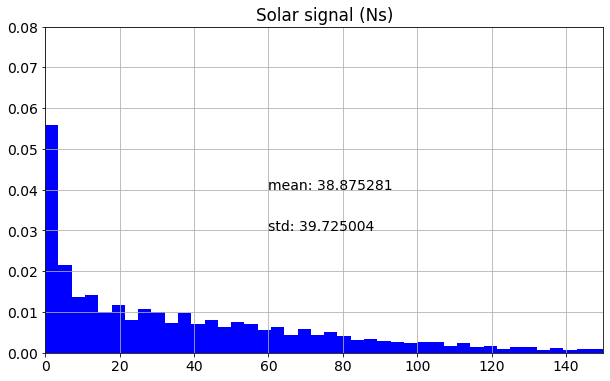

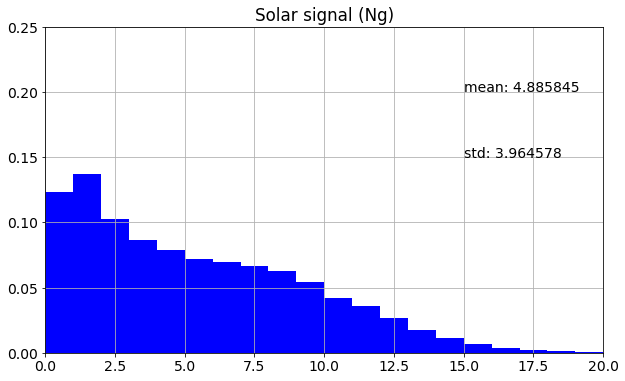

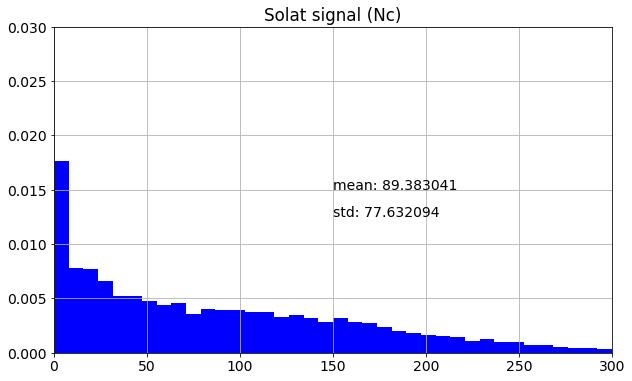

In [4]:
### Solar signal
mus_Ns = median_transformed(Ns, period_rescaling=8)
mus_Ng = median_transformed(Ng, period_rescaling=14)
mus_Nc = median_transformed(Nc, period_rescaling=10)
    
### histograms
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.figure(1)  
plt.hist(mus_Ns[~np.isnan(mus_Ns)], range=[0,150], bins='auto', density=True, facecolor='b')  
plt.title("Solar signal (Ns)")
plt.text(60, 0.04, 'mean: ' '%4f' %np.nanmean(mus_Ns))
plt.text(60, 0.03, 'std: ' '%4f' %np.nanstd(mus_Ns))
plt.axis([0,150, 0, 0.08])
plt.grid(True)
plt.show()
    
plt.figure(2)  
plt.hist(mus_Ng[~np.isnan(mus_Ng)], range=[0,20], bins=20, density=True, facecolor='b')  
plt.title("Solar signal (Ng)")
plt.text(15, 0.2, 'mean: ' '%4f' %np.nanmean(mus_Ng))
plt.text(15, 0.15, 'std: ' '%4f' %np.nanstd(mus_Ng))
plt.axis([0, 20, 0, 0.25])
plt.grid(True)
plt.show()
    
plt.figure(3)  
plt.hist(mus_Nc[~np.isnan(mus_Nc)], range=[0,300], bins='auto', density=True, facecolor='b')  
plt.title("Solat signal (Nc)")
plt.text(150, 0.015, 'mean: ' '%4f' %np.nanmean(mus_Nc))
plt.text(150, 0.0125, 'std: ' '%4f' %np.nanstd(mus_Nc))
plt.axis([0, 300, 0, 0.03])
plt.grid(True)
plt.show()

We are now in a position to analyze the errors: $\epsilon_3$, $\epsilon_1$ and $\epsilon_2$. To do so, we separate minima from non-minima regimes. We also consider two time-scales: short-term periods, that is, time-scales smaller than one solar rotation (27 days), and long-term periods. <br>
We first estimate the error at solar minima, i.e. when $s(t)=0$, then analyze short-term variability of the rescaled observations when $s(t)>0$. For the study of long-term error, we use raw data that did not undergo any rescaling, in order to be able to detect sudden jumps and/or large-drifts in the time series. 

## Error at minima

$\epsilon_3$ denotes the error occurring during minima of solar activity, when there exist extended periods with no or few sunspots. We assume the error $\epsilon_3$ to be significant when there are no sunspots ($s(t)=0$) and otherwise negligible in order to not interfere with the errors $\epsilon_1$ and $\epsilon_2$.
Therefore, observed values of the error at  minima, $\epsilon_3$, are defined as counts made by the stations when the proxy for $s(t)$ is equal to zero: <br>

$$ \hat\epsilon_3(i,t) = Z_i(t) \ \text{when} \ \hat \mu_s(t)=0 $$

In [5]:
def error_at_minima(data, period_rescaling):
    """ 
    This function computes the error at solar minima (epsilon3(i,t))
    of the stations.
    
    Parameters
    ------
    data : 2D-array 
        A matrix of observations: either Ns, Ng or Nc
        (rows: time, columns: stations).
    period_rescaling : float>0
        Length of the period where the scaling-factors are assumed to be 
        constant, expressed in months.
        Using a statistical procedure based on Kruskal-Wallis tests, 
        the minimum value for this parameter is found to be equal to 
        8 months for Ns, 14 months for Ng and 10 months for Nc.
        
    Returns
    -------
    e3 : 2D-array               
        The errors of the stations at solar minima.
        
    """
    assert np.ndim(data) == 2, "Input data must be a 2D array"
    (n_obs, n_stations) = data.shape
    data_rescaled = rescaling(data, period_rescaling)
    mu_s = median_transformed(data, period_rescaling)
    
    e3 = np.zeros((n_obs, n_stations)); e3[:] = np.nan
    for i in range(n_obs):
        if mu_s[i] == 0: #when mu_s(t)=0
            e3[i,:] = data_rescaled[i,:] #Zi(t)

    return e3

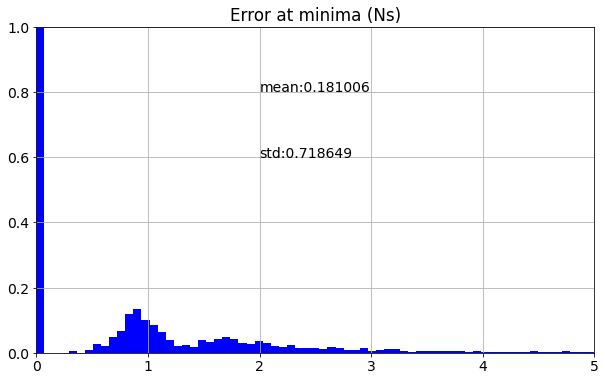

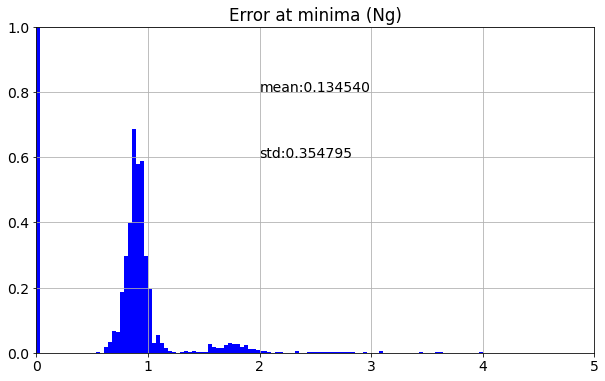

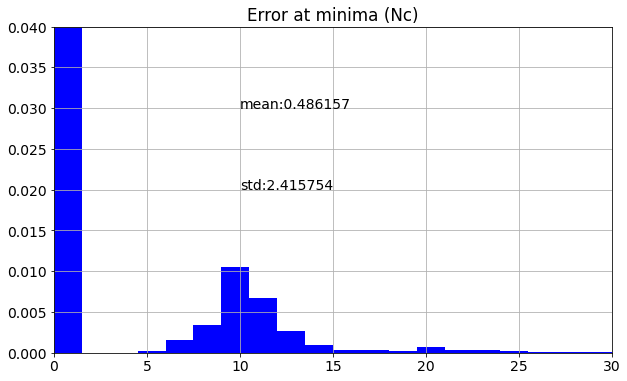

In [6]:
### Error at minima
e3_Ns = error_at_minima(Ns, period_rescaling=8)
e3_Ng = error_at_minima(Ng, period_rescaling=14)
e3_Nc = error_at_minima(Nc, period_rescaling=10)
    
### histograms
binning = int(6/(3.5*np.nanstd(e3_Ns)*len(e3_Ns)**(-1/3))) #Scott's rule
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.figure(1)  
plt.hist(e3_Ns[~np.isnan(e3_Ns)], range=[0,5], bins=binning, density=True, facecolor='b')  
plt.title("Error at minima (Ns)")
plt.text(2, 0.8, 'mean:' '%4f' %np.nanmean(e3_Ns))
plt.text(2, 0.6, 'std:' '%4f' %np.nanstd(e3_Ns))
plt.axis([0, 5, 0, 1])
plt.grid(True)
plt.show()
    
binning = int(6/(3.5*np.nanstd(e3_Ng)*len(e3_Ng)**(-1/3)))
plt.figure(2)  
plt.hist(e3_Ng[~np.isnan(e3_Ng)], range=[0,5], bins=binning, density=True, facecolor='b')  
plt.title("Error at minima (Ng)")
plt.text(2, 0.8, 'mean:' '%4f' %np.nanmean(e3_Ng))
plt.text(2, 0.6, 'std:' '%4f' %np.nanstd(e3_Ng))
plt.axis([0, 5, 0, 1])
plt.grid(True)
plt.show()
    
binning = int(6/(3.5*np.nanstd(e3_Nc)*len(e3_Nc)**(-1/3)))
plt.figure(3)  
plt.hist(e3_Nc[~np.isnan(e3_Nc)], range=[0,30], bins=binning, density=True, facecolor='b')  
plt.title("Error at minima (Nc)")
plt.text(10, 0.03, 'mean:' '%4f' %np.nanmean(e3_Nc))
plt.text(10, 0.02, 'std:' '%4f' %np.nanstd(e3_Nc))
plt.axis([0, 30, 0, 0.04])
plt.grid(True)
plt.show()

## Error at short-term 

When the proxy for s(t) is different from zero, the short-term error $\epsilon_1$ may be estimated using: <br>

$$ \widehat{ \widetilde{\epsilon}}(i,t) = \frac{Z_i(t)}{\hat \mu_s(t)}~ \ \text{when} \ \hat \mu_s(t)>0 $$

where $\widehat{ \widetilde{\epsilon}}(i,t) = \epsilon_1(i,t) + \epsilon_2(i,t)$. 

In [7]:
def short_term_error(data, period_rescaling):
    """ 
    This function computes the short-term error (epsilon_tilde(i,t) := epsilon1(i,t)
    + epsilon2(i,t)), i.e. errors inferior to 27 days, of the stations.
    
    Parameters
    ----------
    data : 2D-array 
        A matrix of observations: either Ns, Ng or Nc
        (rows: time, columns: stations).
    period_rescaling : float>0
        Length of the period where the scaling-factors are assumed to be 
        constant, expressed in months.
        Using a statistical procedure based on Kruskal-Wallis tests, 
        the minimum value for this parameter is found to be equal to 
        8 months for Ns, 14 months for Ng and 10 months for Nc.
        
    Returns
    ------
    e1 : 2D-array   
        The short-term errors of the stations.
        
    """
    assert np.ndim(data) == 2, "Input data must be a 2D array"
    (n_obs, n_stations) = data.shape
    data_rescaled = rescaling(data, period_rescaling)
    mu_s = median_transformed(data, period_rescaling)
    
    e1 = np.zeros((n_obs, n_stations)); e1[:] = np.nan
    for i in range(n_obs):
        if mu_s[i] > 0 and mu_s[i] != np.nan:
            e1[i,:] = data_rescaled[i,:]/mu_s[i] #Z(i,t)/mu_s(t)
            
    return e1 

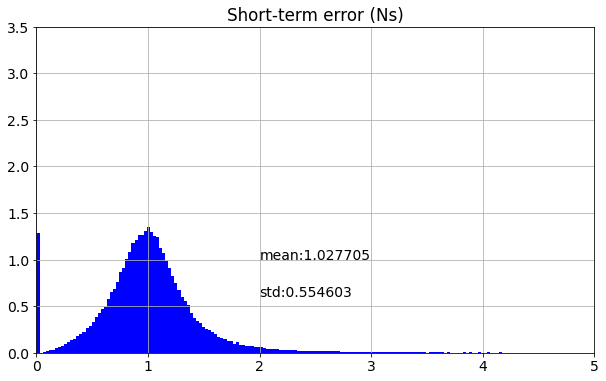

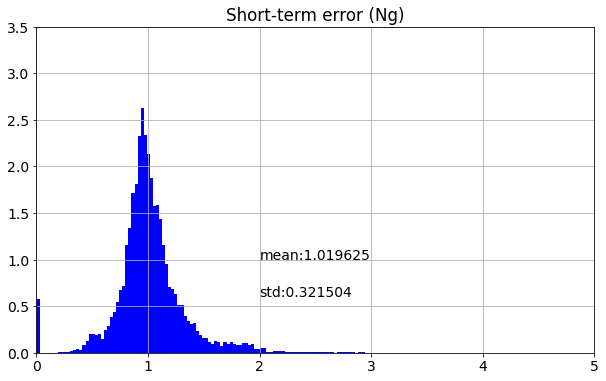

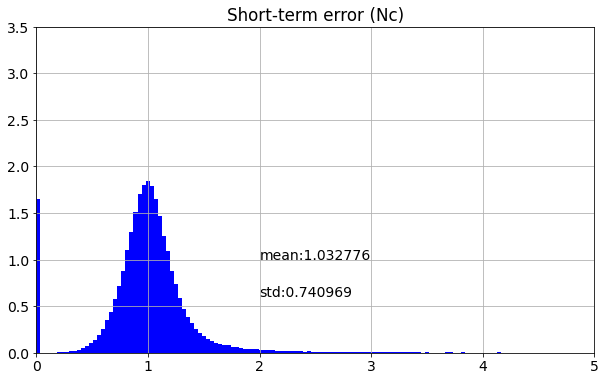

In [8]:
    ### Short-term error
    e1_Ns = short_term_error(Ns, period_rescaling=8)
    e1_Ng = short_term_error(Ng, period_rescaling=14)
    e1_Nc = short_term_error(Nc, period_rescaling=10)
    
    ###histograms
    binning = int(6/0.0328) #Scott's rule for the binning
    plt.rcParams['figure.figsize'] = (10.0, 6.0)
    plt.figure(1)  
    plt.hist(e1_Ns[~np.isnan(e1_Ns)], range=[0,5], bins=binning, density=True, facecolor='b')  
    plt.title("Short-term error (Ns)")
    plt.text(2, 1, 'mean:' '%4f' %np.nanmean(e1_Ns))
    plt.text(2, 0.6, 'std:' '%4f' %np.nanstd(e1_Ns))
    plt.axis([0, 5, 0, 3.5])
    plt.grid(True)
    plt.show()
    
    binning = int(6/0.0328)
    plt.figure(2)  
    plt.hist(e1_Ng[~np.isnan(e1_Ng)], range=[0,5], bins=binning, density=True, facecolor='b')  
    plt.title("Short-term error (Ng)")
    plt.text(2, 1, 'mean:' '%4f' %np.nanmean(e1_Ng))
    plt.text(2, 0.6, 'std:' '%4f' %np.nanstd(e1_Ng))
    plt.axis([0, 5, 0, 3.5])
    plt.grid(True)
    plt.show()
    
    binning = int(6/0.0433)
    plt.figure(3)  
    plt.hist(e1_Nc[~np.isnan(e1_Nc)], range=[0,5], bins=binning, density=True, facecolor='b')  
    plt.title("Short-term error (Nc)")
    plt.text(2, 1, 'mean:' '%4f' %np.nanmean(e1_Nc))
    plt.text(2, 0.6, 'std:' '%4f' %np.nanstd(e1_Nc))
    plt.axis([0, 5, 0, 3.5])
    plt.grid(True)
    plt.show()

## Error at long-term

Finally, a generic estimator for the long-term error $\epsilon_2(i; t)$ may be defined by:

$$ \hat \mu_2(i,t) = \left( \frac{ Y_i(t)}{M_t} \right)^\star ~ \ \text{when} \ M_t>0 $$

where the $\star$ denotes the smoothing process, $Y_i(t)$ are the raw observations and $M_t=\underset{1 \leq i\leq N}{\text{med}} Z_i(t)$ is the median of the network. The $T$ transform is not required here, as we apply a moving average (MA) of length $L$. <br>

This length $L$ should be larger than what is considered as short-term, i.e. periods inferior to one solar rotation
(27 days). Long-term is usually defined as periods equal to or larger than 27 days, where 27 days appears to be an appropriate scale to monitor the jumps while one or two years are better suited to study the drifts. 

<!-- <a id="ref-6" href="#cite-Dudok2016">(Dudok de Wit 2011)</a>, beyond
which the effects of the solar rotation and of the sunspot's lifetime are negligible.
-->


In [9]:
def level_removal(x, wdw, center=True):
    """
    Removes the intrinsic levels of an initial array of series.
    
    This function applies a smoothing process in time by a moving-average
    (MA) filter on each individual series. Then, the smoothed series are
    substracted from the initial series to remove the levels of the 
    processes.
    
    Parameters
    ---------
    x : 2D-array 
        A panel of series (rows: time, columns: series).
    wdw : int
        Length of the MA window length, expressed in days. 
    center : str, optional
        Flag to indicate that the moving windows should be centered with respect 
        to the data. Otherwise, the windows are left-shifted to include only 
        the current and past observations. The default is True.
        
    Returns
    -------
   x_wht_levels : 2D-array
        The array without intrinsic levels.
        
    """
    assert np.ndim(x) == 2, "Input data must be a 2D array"
    (n_obs, n_stations) = x.shape
    x_wht_levels = np.copy(x)
    
    assert wdw > 0, "Window length must be a postive integer"
    wdw = np.round(wdw)
        
    if center:
        if wdw % 2 == 1:
            halfwdw = int((wdw - 1)/2)
        else:
            wdw += 1
            halfwdw = int((wdw - 1)/2)
        for i in range(n_stations):
            m = np.nanmean(x[:,i])
            ma = np.ones((n_obs))*m
            for j in range(n_obs):
                if j < halfwdw: #beginning
                    ma[j] = np.nanmean(x[0:wdw,i])
                elif j >= halfwdw and j < n_obs - halfwdw: #middle
                    ma[j] = np.nanmean(x[j-halfwdw :j+halfwdw+1,i])
                else: #end
                    ma[j] = np.nanmean(x[n_obs-wdw :n_obs,i])
            ma[np.isnan(ma)] = m
            x_wht_levels[:,i] = x_wht_levels[:,i] - ma
            
    if not center:
        for i in range(n_stations):
            m = np.nanmean(x[:,i])
            ma = np.ones((n_obs))*m
            for j in range(n_obs):
                if j < wdw: #beginning
                    ma[j] = np.nanmean(x[0:wdw,i]) 
                else: #remaining part
                    ma[j] = np.nanmean(x[j - wdw+1:j+1,i]) 
            ma[np.isnan(ma)] = m
            x_wht_levels[:,i] = x_wht_levels[:,i] - ma
            
        
    return x_wht_levels
    

def long_term_error(data, period_rescaling, wdw=81, min_perc_per_wdw=10,
                    level=False, wdw_level=4000, center=True):
    """ 
    This function computes the long-term error (mu2(i,t)), i.e. errors 
    superior or equal to 27 days, of the stations.
    
    The function also integrates the possibility to remove the intrinsic 
    level of the stations (which are similar to a 'long long term error'
    and are often denoted by 'h'). 
    Those account e.g. for differences of instruments or location and 
    therefore do not represent actual errors. 
    
    
    Parameters
    ---------
    data : 2D-array 
        A matrix of observations: either Ns, Ng or Nc
        (rows: time, columns: stations).
    period_rescaling : float>0
        Length of the period where the scaling-factors are assumed to be 
        constant, expressed in months.
        Using a statistical procedure based on Kruskal-Wallis tests, 
        the minimum value for this parameter is found to be equal to 
        8 months for Ns, 14 months for Ng and 10 months for Nc.
    wdw : int>0, optional
        MA filter window length, expressed in days. 
        This parameter should be superior than or equal to 27 days. 
        Common scales are 27, 81, 365 or 900 days. The default is 81.
    min_perc_per_wdw : int, optional
        Minimum percentage of obs required per window to compute a value for
        that day (otherwise NaN). Default is ten percents. 
    level: bool, optional 
        Flag to remove the intrinsic level of the stations.
        When True, 'wdw_level' should be set to integer. The default is False. 
    wdw_level : int, optional
        MA filter window length to remove the levels, expressed in days. 
        The default is 4000 (which correspond to roughly eleven years or 
        one solar cycle).
    center : str, optional
        Flag to indicate that the moving windows should be centered with respect 
        to the data. Otherwise, the windows are left-shifted to include only 
        the current and past observations. The default is True. 
        
    Returns
    ------
    mu2 : 2D-array
        The long-term errors of the stations.
        
    """
    assert np.ndim(data) == 2, "Input data must be a 2D array"
    (n_obs, n_stations) = data.shape
    data_rescaled = rescaling(data, period_rescaling)
    Mt = np.round(np.nanmedian(data_rescaled, axis=1))
    
    ratio = np.zeros((n_obs, n_stations))
    ratio[:] = np.nan
    for i in range(n_obs):
        if not np.isnan(Mt[i]) and Mt[i] > 0:
            ratio[i,:] = data[i,:]/Mt[i] #Yi(t)/Mt

    assert wdw > 0, "Window length must be strictly positive"
        
    ### smoothing procedure
    mu2 = np.ones((n_obs, n_stations)); mu2[:] = np.nan
    
    if not center:
        for i in range(n_stations):
            for j in range(n_obs):
                if j < wdw: #beginning
                    m = ratio[0:wdw,i]
                else: #remaining part
                    m = ratio[j - wdw+1:j+1,i]
                if len(m[~np.isnan(m)]) > np.round(wdw/min_perc_per_wdw):
                    mu2[j,i] = np.nanmean(m) #(Yi(t)/Mt)*
                    
                
    elif center:           
        if wdw % 2 == 1:
            halfwdw = int((wdw - 1)/2)
        else:
            wdw += 1
            halfwdw = int((wdw - 1)/2)
        
        for i in range(n_stations):
            for j in range(n_obs):
                if j < halfwdw: #beginning
                    m = ratio[0:wdw,i]
                elif j >= halfwdw and j < n_obs - halfwdw: #middle
                    m = ratio[j - halfwdw:j + halfwdw + 1,i]
                else: #end
                    m = ratio[n_obs - wdw:n_obs,i]
                if len(m[~np.isnan(m)]) > np.round(wdw/min_perc_per_wdw):
                    mu2[j,i] = np.nanmean(m) #(Yi(t)/Mt)*
             
    if level: 
        #remove the intrinsic level of the stations
        mu2 = level_removal(mu2, wdw_level, center=center)
        
    return mu2

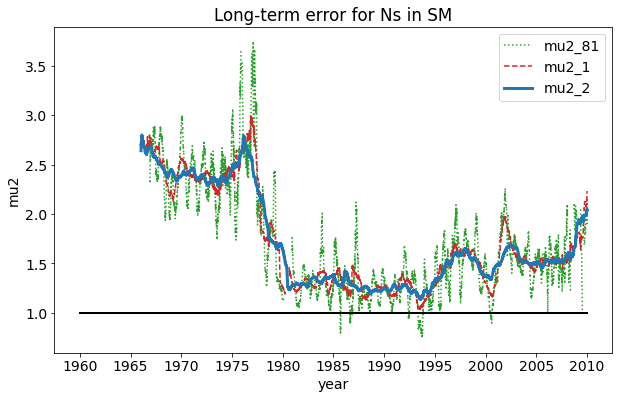

In [10]:
### Long-term error 
mu2_81 = long_term_error(Ns, period_rescaling=8, wdw=81)
mu2_1 = long_term_error(Ns, period_rescaling=8, wdw=365)
mu2_2 = long_term_error(Ns, period_rescaling=8, wdw=912)
    
start = np.where(time == 1960)[0][0]
stop = np.where(time == 2010)[0][0]
stat = 19
plt.plot(time[start:stop], mu2_81[start:stop, stat], ':', c='tab:green', label='mu2_81')
plt.plot(time[start:stop], mu2_1[start:stop, stat], '--', c='tab:red', label='mu2_1')
plt.plot(time[start:stop], mu2_2[start:stop, stat], lw=3, c='tab:blue', label='mu2_2')
plt.plot([time[start], time[stop]], [1, 1], 'k-', lw=2)
plt.legend(loc='upper right')
if stop-start < 4000:
    x_ticks = np.arange(np.round(time[start]), np.round(time[stop])+1, 1)
else :
    x_ticks = np.arange(np.round(time[start]), np.round(time[stop])+1, 5)
plt.xticks(x_ticks)
plt.title("Long-term error for Ns in %s" %station_names[stat])
plt.ylabel('mu2')
plt.xlabel('year')
plt.tick_params(axis='x', which='major')
plt.show()

# Other products 

## Variability / sigma

The different quantities analyzed previously vary in time. Most of them are also station dependent. 
Therefore, it may be interesting to compute the mean and the variance of them, station by station or for all stations together, on a small period of time or on the complete period studied. <br>
To do so, the following function may then be applied on various quantities with desired parameters. 
It contains the following arguments: 
- x : the quantity of interest
- station : flag to compute the mean and standard deviation (std) station by station.
- period : period on which the mean and std are computed, in days
- robust : flag to use robust estimators (i.e. the median and the interquartile range)

In [11]:
def stats(x, station=True, period=None, robust=False):
    """
    Computes the mean and the standard deviation of a quantity 'x'. 
    This function may be applied in general on any quantity (errors, 
    observations, median, etc.).

    Parameters
    ----------
    x : 2D-array
        An initial array (rows: time, columns: stations).
        1D-arrays may be transformed into 2D-arrays using 'x.reshape(-1,1)'.
    station : bool, optional
        Flag to compute the mean and the standard deviation station by station.
        Otherwise, all stations are agglomerated in the computations.
        The default is True.
    period : integer > 0, optional
        Period on which the mean and the standard deviation are computed, 
        expressed in days (365 = one year). 
        When None, the entire period is used. The default is None.
    robust : bool, optional
        Flag to use robust estimator of the mean and the standard deviation 
        (i.e.: the median and the interquartile range). The default is False.
    
    Returns
    -------
    x_mean : 2D-array
         The mean of the quantity 'x'.
    x_std : 2D-array
         The standard deviation of the quantity 'x'.
         
    """
    assert np.ndim(x) == 2, "Input data must be a 2D array."
    (n_obs, n_stations) = x.shape
    
    if period is None:
        period = n_obs #entire period used
    
    n_rows = int(np.ceil(n_obs / period))
    if not station: #all station together
        x_mean = np.zeros((n_rows,1)); x_mean[:] = np.nan
        x_std = np.zeros((n_rows,1)); x_std[:] = np.nan
        c = 0
        for i in range(0, n_obs, period):
             if i < n_obs-period:
                if not robust: 
                    x_mean[c] = np.nanmean(x[i:i+period])
                    x_std[c] = np.nanstd(x[i:i+period])
                else: #robust estimators
                    x_mean[c] = np.nanmedian(x[i:i+period])
                    x_std[c] = iqr(x[i:i+period], nan_policy='omit')
             else:
                if not robust: 
                    x_mean[c] = np.nanmean(x[i:i+n_obs])
                    x_std[c] = np.nanstd(x[i:i+n_obs])
                else: #robust estimators
                    x_mean[c] = np.nanmedian(x[i:i+n_obs])
                    x_std[c] = iqr(x[i:i+n_obs], nan_policy='omit')
             c += 1
            
        
    if station: ### station by station
        x_mean = np.zeros((n_rows, n_stations)); x_mean[:] = np.nan
        x_std = np.zeros((n_rows, n_stations)); x_std[:] = np.nan
        c = 0
        for i in range(0, n_obs, period):
            if i < n_obs-period:
                for j in range(n_stations):
                    if not robust:
                        x_mean[c,j] = np.nanmean(x[i:i+period,j])
                        x_std[c,j] = np.nanstd(x[i:i+period,j])
                    else: #robust estimators
                        x_mean[c,j] = np.nanmedian(x[i:i+period,j])
                        x_std[c,j] = iqr(x[i:i+period,j], nan_policy='omit')
            else: #last observations 
                for j in range(n_stations):
                    if not robust:
                        x_mean[c,j] = np.nanmean(x[i:i+n_obs,j])
                        x_std[c,j] = np.nanstd(x[i:i+n_obs,j])
                    else: #robust estimators
                        x_mean[c,j] = np.nanmedian(x[i:i+n_obs,j])
                        x_std[c,j] = iqr(x[i:i+n_obs,j], nan_policy='omit')
            c += 1
                
    return x_mean, x_std

## Measure of stability (at short-term and long-term)

A measure of the stability of the stations is also interesting, to define a robust reference of the network (other than the median) as well as for the monitoring procedure. <br>
For this purpose, we propose to use the mean-squarred error (MSE), a widely-used criterion involving the variability of the series and their bias: <br> 

$$ MSE[\hat x] = bias^2[\hat x] + variance[\hat x] = (E[\hat x] - x)^2 + Var[\hat x]. $$

Since the errors are assumed to be independent, a combined measure of the stability of the stations at the short-term and long-term may be computed as the sum of the MSE of the long-term error and the MSE of the short-term error :

$$ stability[i] = MSE[\hat \mu_2(i,t)] + MSE[\widehat{\widetilde{\epsilon}}(i,t)]$$

The following function may be used to computed the MSE of the errors. It contains the following arguments: 
- x : the quantity of interest (the short-term or the long-term error)
- names : the code names of all stations of the panel
- ref : the 'true' value of x (used to compute the bias). 
- robust : flag to use robust estimators (i.e. the median and the interquartile range)

In [12]:
def mse_criterion(x, names, ref=None, robust=False):
    """
    Computes the mean-squarred error (mse) of a quantity 'x'
    in each station.
    
    This criterion combines the variance of the series with their bias
    with respect to a reference. It may be used as a stability criterion, 
    for clustering or ranking the stations. 

    Parameters
    ----------
    x : 2D-array
        An initial array (rows: time, columns: stations).
        This function may be applied in general on any quantity that is station- 
        dependent such as the errors or the observations (Ns, Ng, Nc).
    names : list
        A list containing the code names of the stations.
    ref : float, optional
        The reference value for the quantity 'x' (used to compute the bias).
        When None, the reference is taken as the mean value of 
        x. The default is None.
    robust : bool, optional
        Flag to compute the mse on robust estimators (i.e. the median 
        and the interquartile range). The default is False.

    Returns
    -------
    mse : 1D-array
        The mean-squarred error in each station.
    order_names : list
        The index of the stations sorted from the most stable series (minimum
        mse value) to the most unstable one (max mse value).

    """
    assert np.ndim(x) == 2, "Input data must be a 2D array"
    (n_obs, n_stations) = x.shape
    
    if ref is None:
        if robust:
            ref = np.nanmedian(x)
        else:
            ref = np.nanmean(x)
    
    mse = np.zeros(n_stations)
    for i in range(n_stations):
        if robust:
            mse[i] = (np.nanmedian(x[:,i]-ref))**2 + iqr(x[:,i], nan_policy='omit') 
        else:
            mse[i] = (np.nanmean(x[:,i]-ref))**2 + np.nanvar(x[:,i]) 
        
    ind_order = np.argsort(mse)
    order_names = [names[i] for i in ind_order]
            
    return mse, order_names


We now compute the combined index of the stability of the stations by adding the MSE of the short-term error to the MSE of the long-term error. To be meaningful, we first remove the levels of the stations in the long-term errors, since we do not want to discriminate the stations based on their instruments or counting methodology but only based on their errors. We remove the level of the stations each eleven year (wdw_level = 4000) to conserve the long-term drifts that some stations may have experienced. <br>
At short-term, our model writes as:

$$ Yi(t) = (\epsilon_1(i,t) + \epsilon_2(i,t))s(t) = \widetilde{\epsilon}(i,t) s(t). $$

When a station is perfectly aligned with the reference, $\widetilde{\epsilon}(i,t)=1$. <br>
At long-term, $\epsilon_2(i,t)=1$ also reflects a perfect station with respect to our reference: 

$$ Yi(t)^\star = \epsilon_2(i,t)s(t)^\star. $$

For a perfect station without level, this is equivalent to $\epsilon_2(i,t)=0$. <br>
Therefore, we choose '1' as the reference for the short-term error and '0' for the reference value of the long-term error without level in the following. Those values are used to compute the bias of the stations at short-term and long-term. 

$$ MSE[\hat \mu_2(i,t)] = (E[\hat \mu_2(i,t)] - 0)^2 + Var[\hat \mu_2(i,t)]. $$
$$ MSE[\widehat{\widetilde{\epsilon}}(i,t)] = (E[\widehat{\widetilde{\epsilon}}(i,t)] - 1)^2 + Var[\widehat{\widetilde{\epsilon}}(i,t)]. $$


In [13]:
#compute the long-term errors without intrinsic levels 
mu2_81 = long_term_error(Ns, period_rescaling=8, wdw=81, level=True, wdw_level=4000)

#compute the mse of the short-term and the long-term error and take the sum
mse_add = mse_criterion(e1_Ns, station_names, ref=1)[0] + \
                        mse_criterion(mu2_81, station_names, ref=0)[0]
ind_order = np.argsort(mse_add)
names_add = [station_names[i] for i in ind_order]
print(names_add)
    
#compute the mse of the sum of short-term and the long-term errors 
#should be the same as the previous computation if the errors were perfectly independent
mse_comb, names_comb = mse_criterion(e1_Ns+mu2_81, station_names, ref=1)
print(names_comb)

['CRA', 'LFm', 'KOm', 'BN-S', 'FU', 'A3', 'PO', 'SC-S', 'MO', 'HU', 'CA', 'KH', 'HD-S', 'KZm', 'KS2', 'MA', 'SM', 'SK', 'UC', 'LO', 'QU']
['CRA', 'LFm', 'KOm', 'BN-S', 'FU', 'PO', 'SC-S', 'HU', 'MO', 'A3', 'CA', 'KH', 'HD-S', 'KZm', 'KS2', 'MA', 'SK', 'SM', 'UC', 'LO', 'QU']


## Individual errors (error bars)

We can also compute error bars for the stations at each time. To be more easily interpreted, we may rewrite our multiplicative model into an additive framework. At short-term, the model becomes:

$$ Yi(t) = \widetilde{\epsilon}(i,t) s(t) = s(t) + s(t)(\widetilde{\epsilon}(i,t) -1), $$

where the first term of the equation represents the reference value for that day and the second one corresponds to the additive error of the individual station $i$. The sign of this error reflects the fact that the station sees more or less spots than the reference. <br>
The following function computes the additive error of the stations, $s(t)(\widetilde{\epsilon}(i,t) -1)$, and the reference, $s(t)$, at each time. 

In [14]:
def error_add(data, period_rescaling):
    """
    Computes an additive error for each station at each time
    (Yi(t) = s(t) + s(t)(epsilon_tilde -1) ).

    Parameters
    ----------
    data : 2D-array
        A matrix of observations: either Ns, Ng or Nc
        (rows: time, columns: stations).
    period_rescaling : float>0
        Length of the period where the scaling-factors are assumed to be 
        constant, expressed in months.
        Using a statistical procedure based on Kruskal-Wallis test, 
        the minimum value for this parameter is found to be equal to 
        8 months for Ns, 14 months for Ng and 10 months for Nc.

    Returns
    -------
    err_add : 2D-array
        The additive errors of the stations.
    ref : 1D-array
        The transformed median (reference) of the network.
        
    """
    assert np.ndim(data) == 2, "Input data must be a 2D array"
    (n_obs, n_stations) = data.shape
    
    ref = median_transformed(data, period_rescaling)
    e1 = short_term_error(data, period_rescaling) 
    
    err_add = np.zeros((n_obs, n_stations)); err_add[:] = np.nan
    for i in range(n_obs):
        for j in range(n_stations):
            if ref[i] > 0: 
                err_add[i,j] = ref[i]*(e1[i,j]-1)
             
    return err_add, ref



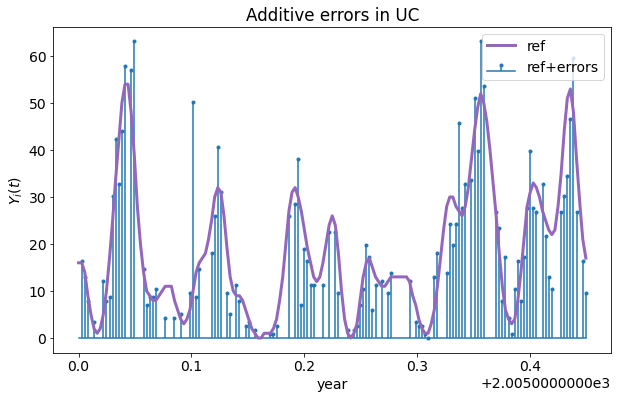

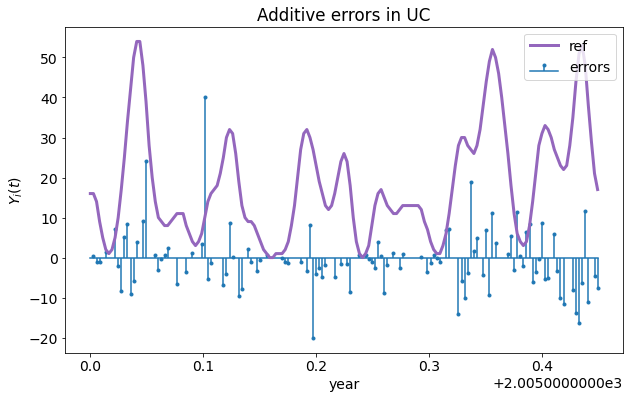

In [15]:
add, ref = error_add(Ns, period_rescaling=8)

start = np.where(time == 2005)[0][0]
stop = np.where(np.round(time,1) == 2005.5)[0][0]
stat = 20

plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.stem(time[start:stop], ref[start:stop]+add[start:stop, stat], label='ref+errors', markerfmt='C0.', basefmt='C0-')
plt.plot(time[start:stop], ref[start:stop], c='tab:purple', label='ref', lw=3)
plt.legend(loc='upper right')
if stop-start < 4000:
    x_ticks = np.arange(np.round(time[start],1), np.round(time[stop],1), 0.1)
else :
    x_ticks = np.arange(np.round(time[start]), np.round(time[stop])+1, 5)
plt.xticks(x_ticks)
plt.title("Additive errors in %s" %station_names[stat])
plt.ylabel('$Y_i(t)$')
plt.xlabel('year')
plt.tick_params(axis='x', which='major')
plt.show()


plt.stem(time[start:stop], add[start:stop, stat], label='errors', markerfmt='C0.', basefmt='C0-')
plt.plot(time[start:stop], ref[start:stop], c='tab:purple', label='ref', lw=3)
plt.legend(loc='upper right')
if stop-start < 4000:
    x_ticks = np.arange(np.round(time[start],1), np.round(time[stop],1), 0.1)
else :
    x_ticks = np.arange(np.round(time[start]), np.round(time[stop])+1, 5)
plt.xticks(x_ticks)
plt.title("Additive errors in %s" %station_names[stat])
plt.ylabel('$Y_i(t)$')
plt.xlabel('year')
plt.tick_params(axis='x', which='major')
plt.show()


Having defined an additive error, we can now provide error bars for each station as a function of time. 
This can be done with the following function. <br>
The function first computes the additive error in each station and at each time. Then, it computes running distributions of this error on ```n_bars``` observations as a function of time in each station. The quantiles of those distributions are finally calculated and returned by the function. They correspond to the lower and upper error bars of the stations. 

In [16]:
def error_bars(data, period_rescaling, n_bars=365, center=True, qt=0.05):
    """
    Computes error bars for the stations at each time.
    
    This function first computes an additive error for the stations 
    at each time (Yi(t) = s(t) + s(t)(epsilon_tilde -1) ). Then, it 
    calculates the empirical quantiles of the additive error distribution,
    as a function of time. 
    Those quantiles are obtained on running distributions containing
    'n_bars' observations. 

    Parameters
    ----------
    data : 2D-array
        A matrix of observations: either Ns, Ng or Nc
        (rows: time, columns: stations).
    period_rescaling : float>0
        Length of the period where the scaling-factors are assumed to be 
        constant, expressed in months.
        Using a statistical procedure based on Kruskal-Wallis test, 
        the minimum value for this parameter is found to be equal to 
        8 months for Ns, 14 months for Ng and 10 months for Nc.
    n_bars : int>0, optional
        Number of obs. used to compute the distribution of the additive 
        error, expressed in days. 
        This parameter should be superior than zero. The default is 365.
    center : str, optional
        Flag to indicate that the error distributions should be 
        computed using data centered around a particular obs.
        Otherwise, the distributions are computed using the
        current and past observations only. 
        The default is True. 
    qt : float in [0,1], optional
        The chosen level of confidence for the error bars.
        The default is 0.05. 

    Returns
    -------
    bars_m : 2D-array
        The lower error bars of the stations.
    bars_p : 2D-array
        The upper error bars of the stations.
    ref : 1D-array
        The transformed median (reference) of the network.
        
    """
    assert np.ndim(data) == 2, "Input data must be a 2D array"
    assert n_bars > 0, "n_bars must be strictly positive"
    assert qt>=0 and qt<=1, "Quantile must be in [0,1]"
    (n_obs, n_stations) = data.shape
    
    ref = median_transformed(data, period_rescaling)
    e1 = short_term_error(data, period_rescaling) 
    
    #compute additive error
    err_add = np.zeros((n_obs, n_stations)); err_add[:] = np.nan
    for i in range(n_obs):
        for j in range(n_stations):
            if ref[i] > 0: 
                err_add[i,j] = ref[i]*(e1[i,j]-1)
      
    bars_p = np.zeros((n_obs, n_stations)); bars_p[:] = np.nan
    bars_m = np.zeros((n_obs, n_stations)); bars_m[:] = np.nan
    
    #compute running empirical quantiles 
    if not center:
        for i in range(n_stations):
            for j in range(n_obs):
                if j < n_bars: #beginning
                    m = err_add[0:n_bars,i]
                else: #remaining part
                    m = err_add[j - n_bars +1:j+1,i]
                m_ntnan = m[~np.isnan(m)]
                if len(m_ntnan) > 0:
                    bars_m[j,i] = np.quantile(m_ntnan, qt/2)
                    bars_p[j,i] = np.quantile(m_ntnan, 1-qt/2)
                    
                
    elif center:           
        if n_bars % 2 == 1:
            halfwdw = int((n_bars - 1)/2)
        else:
            n_bars += 1
            halfwdw = int((n_bars - 1)/2)
        
        for i in range(n_stations):
            for j in range(n_obs):
                if j < halfwdw: #beginning
                    m = err_add[0:n_bars,i]
                elif j >= halfwdw and j < n_obs - halfwdw: #middle
                    m = err_add[j - halfwdw:j + halfwdw + 1,i]
                else: #end
                    m = err_add[n_obs - n_bars:n_obs,i]
                m_ntnan = m[~np.isnan(m)]
                if len(m_ntnan) > 0:
                    bars_m[j,i] = np.quantile(m_ntnan, qt/2)
                    bars_p[j,i] = np.quantile(m_ntnan, 1-qt/2)
             
    return bars_m, bars_p, ref

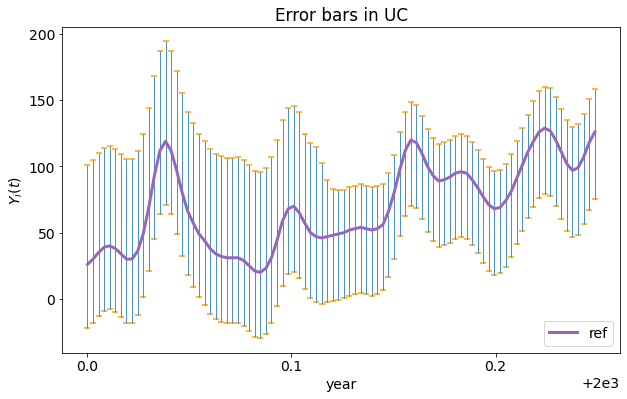

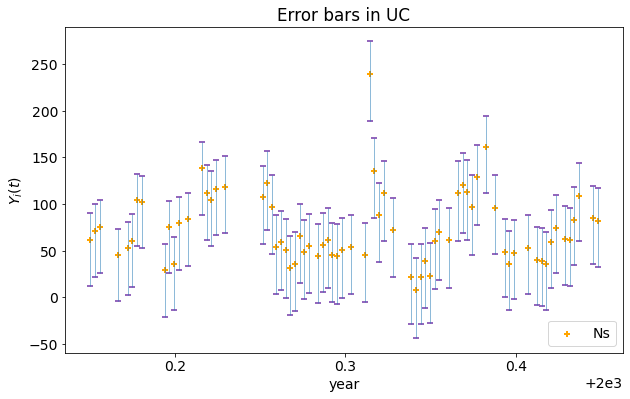

In [17]:
bars_m, bars_p, ref = error_bars(Ns, period_rescaling=8)

stat = 20
start = np.where(time == 2000)[0][0]
stop = np.where(np.round(time,1) == 2000.3)[0][0]

y = ref[start:stop]
bars = np.array((bars_m[start:stop,stat], bars_p[start:stop,stat]))
plt.vlines(time[start:stop], y + bars[0,:], y + bars[1,:], lw=0.8)
plt.scatter(time[start:stop], y + bars[0,:], marker='_', c='orange')
plt.scatter(time[start:stop], y + bars[1,:], marker='_', c='orange')
plt.plot(time[start:stop], y, c='tab:purple', label='ref', lw=3)
if stop-start < 4000:
    x_ticks = np.arange(np.round(time[start],1), np.round(time[stop],1), 0.1)
else :
    x_ticks = np.arange(np.round(time[start]), np.round(time[stop])+1, 5)
plt.xticks(x_ticks)
plt.title("Error bars in %s" %station_names[stat])
plt.ylabel('$Y_i(t)$')
plt.xlabel('year')
plt.tick_params(axis='x', which='major')
plt.legend(loc='lower right')
plt.show()


Ns_rescaled = rescaling(Ns, 8)    
start = np.where(np.round(time,1) == 2000.2)[0][0]
stop = np.where(np.round(time,1) == 2000.5)[0][0]
y = Ns_rescaled[start:stop, stat]

bars = np.array((bars_m[start:stop,stat], bars_p[start:stop,stat]))
plt.scatter(time[start:stop], y, c='orange', marker='+', label='Ns', lw=2)
plt.scatter(time[start:stop], y + bars[0,:], marker='_', c='tab:purple', lw=2)
plt.scatter(time[start:stop], y + bars[1,:], marker='_', c='tab:purple', lw=2)
plt.vlines(time[start:stop], y + bars[0,:], y + bars[1,:], lw=0.5)
plt.title("Error bars in %s" %station_names[stat])
plt.ylabel('$Y_i(t)$')
plt.xlabel('year')
plt.legend(loc='lower right')
if stop-start < 4000:
    x_ticks = np.arange(np.round(time[start],1), np.round(time[stop],1), 0.1)
else :
    x_ticks = np.arange(np.round(time[start]), np.round(time[stop])+1, 5)
plt.xticks(x_ticks)
plt.show()



<!--bibtex

@ARTICLE{Mathieu2019,
AUTHOR={{Mathieu}, S. and {von Sachs}, R. and {Delouille}, V. and {Lefevre}, L. and {Ritter}, C.},
TITLE="{Uncertainty quantification in sunspot counts}",
JOURNAL={The Astrophysical Journal},
YEAR={2019}, 
volume = {886},
number={1}, 
pages= {}, 
doi={https://doi.org/10.3847/1538-4357/ab4990}
}


@article{Kruskal_Wallis,
    author = {{Kruskal}, W. and {Wallis}, W.},
    title ="{Use of ranks in one-criterion variance analysis}",
    journal = {Journal of the American Statistical Association},
    volume = {47},
    number = {260},
    pages = {583-621},
    year = {1952},
    doi = {10.1191/1471082X04st068oa},
    URL = {https://www.jstor.org/stable/2280779}
}

@BOOK{Davenport1987,
   author = {{Davenport}, W. B. and {Root}, W. L. },
   title = "{Random Signals and Noise}",
   publisher={McGraw-Hill},
   year = {1968}
}

@article{Makitalo2013,
    author = {{Makitalo}, M. and {Foi}, A.},
    title ="{Optimal inversion of the generalized Anscombe transformation for Poisson-gaussian noise}",
    journal = {IEEE Transactions on Image Processing},
    volume = {22},
    number = {1},
    pages={91-103},
    year = {2013}, 
    doi ={10.1109/TIP.2012.2202675}
}

@ARTICLE{Dudok2016,
   author = {{Dudok de Wit}, T. and {Lef{\`e}vre}, L. and {Clette}, F.},
   title = "{Uncertainties in the sunspot numbers: estimation and implications}",
   journal = {Solar Physics},
   archivePrefix = {arXiv},
   eprint = {1608.05261},
   primaryClass = {astro-ph.SR},
   year = {2016},
   month = {November},
   volume = {291},
   number ={9-10},
    pages = {2709-2731},
      doi = {10.1007/s11207-016-0970-6},
   adsurl = {http://adsabs.harvard.edu/abs/2016SoPh..291.2709D},
  adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}

-->






# References

<a id="cite-Mathieu2019"/><sup><a href=#ref-1>[^]</a><a href=#ref-3>[^]</a></sup>Mathieu, S. and von Sachs, R. and Delouille, V. and Lefevre, L. and Ritter, C.. 2019. _Uncertainty quantification in sunspot counts_.

<a id="cite-Kruskal_Wallis"/><sup><a href=#ref-2>[^]</a></sup>Kruskal, W. and Wallis, W.. 1952. _Use of ranks in one-criterion variance analysis_. [URL](https://www.jstor.org/stable/2280779)

<a id="cite-Makitalo2013"/><sup><a href=#ref-4>[^]</a></sup>Makitalo, M. and Foi, A.. 2013. _Optimal inversion of the generalized Anscombe transformation for Poisson-gaussian noise_.

<a id="cite-Davenport1987"/><sup><a href=#ref-5>[^]</a></sup>Davenport, W. B. and Root, W. L. . 1968. _Random Signals and Noise_.

<a id="cite-Dudok2016"/><sup><a href=#ref-6>[^]</a></sup>Dudok de Wit, T. and Lef&egrave;vre, L. and Clette, F.. 2016. _Uncertainties in the sunspot numbers: estimation and implications_.

